## 요약

- 저자명 : 1저자만 추출
    - ```extract_author1``` 사용
    - 공저자 등이 있는지에 대한 bool columns을 만듦
- 도서명 : 괄호 안의 내용 분리
    - 각 괄호 별로 들어있는 내용을 추출한 뒤 ', '.join
- 출판사 : 상위 50개를 제외하고는 기타 처리
- 대분류 : 별도의 처리 하지 않되 token 코퍼스에 추가
- 차후 itemid 페이지에 직접 접속하여 DB의 값 업데이트 필요
    - 이 경우 특히 저자명의 경우 다른 방식으로 처리하게 될 예정

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 그래프의 폰트 출력을 선명하게 (svg, retina 등이 있음)
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("default")
# 이미지가 레이아웃 안으로 들어오도록 함
# https://matplotlib.org/stable/users/explain/axes/constrainedlayout_guide.html
mpl.rcParams.update({"figure.constrained_layout.use": True})

#font, line, marker 등의 배율 설정: paper, notebook, talk, poster
sns.set_context("paper") 
#배색 설정: tab10, Set2, Accent, husl
sns.set_palette("Set2") 
#눈금, 배경, 격자 설정: ticks, white, whitegrid, dark, darkgrid
# withegrid: 눈금을 그리고, 각 축의 눈금을 제거
sns.set_style("whitegrid") 

In [2]:
# 로컬에서 

plt.rc("font", family = "D2Coding")
plt.rcParams["axes.unicode_minus"] = False

In [3]:
import os, natsort, re
from tqdm import tqdm
import time, random

In [4]:
PRJCT_PATH = '/home/doeun/code/AI/ESTSOFT2024/workspace/2.project_text/aladin_usedbook/'
save_dir = 'processed'
date = 240711
file_name = f'unused_filtered_{date}.csv'

bookdata_path = os.path.join(PRJCT_PATH,save_dir,file_name)
usedbook_path =PRJCT_PATH+'processed/usedbook_data/usedproduct_unused_filtered_240711_worker_1_10.csv' 

In [5]:
bookinfo = pd.read_csv(bookdata_path)
usedbook_data = pd.read_csv(usedbook_path)

display(bookinfo.head())
display(usedbook_data.head())

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명),source
0,322.0,국내도서,민병철 생활영어 1,54947,9788975121036,13740.0,민병철 지음,민병철스피킹웍스,1979-10-01,5500,4950,270점,177.0,외국어,2001년1월3주
1,767.0,국내도서,행복에의 초대,168173,9788932852218,93230.0,IVP(한국기독학생회출판부) 편집부 엮음,IVP,1979-12-01,2800,2660,20점,1960.0,종교/역학,2005년2월1주
2,449.0,국내도서,훈련으로 되는 제자,458277,9788937501791,NaN,월터 A. 헨릭슨 지음,네비게이토,1980-12-01,4500,4050,220점,552.0,종교/역학,2005년2월1주
3,490.0,국내도서,전태일 평전,128759,9788971990650,NaN,조영래 지음,돌베개,1983-06-01,6000,6000,60점,409.0,사회과학,2001년1월3주
4,300.0,국내도서,제자의 삶,131488,9788937502590,3230.0,프랜시스 M.코스그로브 지음,네비게이토,1984-07-01,12000,12000,360점,1110.0,종교/역학,2005년2월1주


,ItemId,used_idx,delivery_fee,price,quality,store,url
0,1000810,1,2500,5400,중,중고매장동탄2하나로마트점,https://www.aladin.co.kr/shop/wproduct.aspx?It...
1,1000810,10,2500,5600,상,중고매장대전시청역점,https://www.aladin.co.kr/shop/wproduct.aspx?It...
2,1000810,11,2500,5600,중,중고매장의정부홈플러스점,https://www.aladin.co.kr/shop/wproduct.aspx?It...
3,1000810,12,2500,5700,상,중고매장울산점,https://www.aladin.co.kr/shop/wproduct.aspx?It...
4,1000810,13,2500,5700,상,중고매장부천점,https://www.aladin.co.kr/shop/wproduct.aspx?It...


In [6]:
display(bookinfo.info())
display(usedbook_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9328 entries, 0 to 9327
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   순번/순위       9328 non-null   float64
 1   구분          9328 non-null   object 
 2   상품명         9328 non-null   object 
 3   ItemId      9328 non-null   int64  
 4   ISBN13      9264 non-null   object 
 5   부가기호        7886 non-null   object 
 6   저자/아티스트     9328 non-null   object 
 7   출판사/제작사     9328 non-null   object 
 8   출간일         9328 non-null   object 
 9   정가          9328 non-null   int64  
 10  판매가         9328 non-null   int64  
 11  마일리지        9328 non-null   object 
 12  세일즈포인트      9328 non-null   float64
 13  대표분류(대분류명)  9328 non-null   object 
 14  source      9328 non-null   object 
dtypes: float64(2), int64(3), object(10)
memory usage: 1.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6832 entries, 0 to 6831
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ItemId        6832 non-null   int64 
 1   used_idx      6832 non-null   int64 
 2   delivery_fee  6832 non-null   int64 
 3   price         6832 non-null   int64 
 4   quality       6832 non-null   object
 5   store         6832 non-null   object
 6   url           6832 non-null   object
dtypes: int64(4), object(3)
memory usage: 373.8+ KB


None

In [7]:
col_name_dict= {
    '순번/순위' : 'Rank',
    '구분' : 'Partition',
    '상품명' : 'BName',
    '부가기호' : 'AddCode',
    '저자/아티스트' : 'Author',
    '출판사/제작사' : 'Publshr',
    '출간일' : 'Pdate',
    '정가' : 'RglPrice',
    '판매가' : 'SlsPrice',
    '마일리지' : 'Mileage',
    '세일즈포인트' : 'SalesPoint',
    '대표분류(대분류명)' : 'Category',
    'source' : 'Sorce'
}
bookinfo = bookinfo.rename(columns=col_name_dict)
bookinfo

,Rank,Partition,BName,ItemId,ISBN13,AddCode,Author,Publshr,Pdate,RglPrice,SlsPrice,Mileage,SalesPoint,Category,Sorce
0,322.0,국내도서,민병철 생활영어 1,54947,9788975121036,13740.0,민병철 지음,민병철스피킹웍스,1979-10-01,5500,4950,270점,177.0,외국어,2001년1월3주
1,767.0,국내도서,행복에의 초대,168173,9788932852218,93230.0,IVP(한국기독학생회출판부) 편집부 엮음,IVP,1979-12-01,2800,2660,20점,1960.0,종교/역학,2005년2월1주
2,449.0,국내도서,훈련으로 되는 제자,458277,9788937501791,NaN,월터 A. 헨릭슨 지음,네비게이토,1980-12-01,4500,4050,220점,552.0,종교/역학,2005년2월1주
3,490.0,국내도서,전태일 평전,128759,9788971990650,NaN,조영래 지음,돌베개,1983-06-01,6000,6000,60점,409.0,사회과학,2001년1월3주
4,300.0,국내도서,제자의 삶,131488,9788937502590,3230.0,프랜시스 M.코스그로브 지음,네비게이토,1984-07-01,12000,12000,360점,1110.0,종교/역학,2005년2월1주
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,68.0,국내도서,장송의 프리렌 12,342597187,9791141131623,NaN,"야마다 카네히토 지음, 아베 츠카사 그림, 서현아 옮김",학산문화사(만화),2024-07-25,6000,5400,300점,10530.0,만화,2024년7월2주
9324,138.0,국내도서,약사의 혼잣말 13,342597589,9791141137175,NaN,"네코쿠라게 지음, 시노 토우코 그림, 휴우가 나츠 원작, 나나오 이츠키 구성",학산문화사(만화),2024-07-25,6000,5400,300점,5870.0,만화,2024년7월2주
9325,129.0,국내도서,타몬 군 지금 어느 쪽?! 7,342597714,9791141131678,NaN,"시와스 유키 지음, 최윤정 옮김",학산문화사(만화),2024-07-25,6000,5400,300점,6370.0,만화,2024년7월2주
9326,209.0,국내도서,천재 의사 시건방 1,342388828,9791160342147,74810,"강효미 지음, 유영근 그림",머스트비,2024-07-31,13000,11700,650점,8190.0,어린이,2024년7월2주


#### 전처리
- 현재 크롤링 코드 상, 중고 매물 목록에는 결측치가 없음
- 이상치 또한 정의할 필요 없음

- bookinfo DB
    - 발간일 : dt로 변환 
    - 저자 : 
        - 역할 별 분리
    - 제목 :
        - 특이사항 추출 (\[\], () 안의 내용)
        - mecab으로 tokenize 및 encoding
            - tokenize할 때 모든 token을 포함할지 조사 등은 제외할지 판단 필요
        - padding 
    - 출판사 :
        - 그냥 인코딩할지 tokenize이후 encoding할지 고민
        - 차원 측면에서 어떻게 더 나은지 판단 필요
    - 대분류 : (위와 동일)
- usedbook DB
    - quality 인코딩
- 전처리는 아니지만, usedbook DB에 책 이름은 넣는 것이 더 나았을 듯 

### 저자
- 편집자, 편집부로 되어있는 값들도 있는지 추후에 확인 필요

In [8]:
cond = bookinfo.Author.apply(lambda x: '지음' in x)
np.sum(cond)

8614

In [9]:
temp= bookinfo.loc[~cond,'Author']
temp

1                   IVP(한국기독학생회출판부) 편집부 엮음
7                           나관중 원작, 이문열 평역
8                           나관중 원작, 이문열 평역
10                          나관중 원작, 이문열 평역
11                          나관중 원작, 이문열 평역
                       ...                
9243                          여성문학사연구모임 엮음
9263         박현미 그림, 황혜영 글, 최재천 기획, 안선영 해설
9281    도니패밀리 그림, 이종혁 글, 흔한컴퍼니 감수, 흔한남매 원작
9294                                나정현 엮음
9303                삼성출판사 편집부 엮음, 김진영 외 감수
Name: Author, Length: 714, dtype: object

In [10]:
import functools

role_list = ['지음','엮음','그림','글','기획','해석','감수','평역','원작','저자','해설','옮김','편저','극본','소설']
cond_list = [temp.apply(lambda x: role in x) for role in role_list]

cond = functools.reduce(lambda x,y : x|y , cond_list)

res=temp[~cond]
res

19                  조정래
22            한국심장질환연구소
24                  조정래
25                  조정래
28                  김홍경
             ...       
4651           프리드리히 니체
4875                강윤혜
4983    존슨 너새니얼 펄트, 박광호
5387            One (원)
6164           월간 수퍼레시피
Name: Author, Length: 80, dtype: object

In [11]:
res.iloc[0:20]

19           조정래
22     한국심장질환연구소
24           조정래
25           조정래
28           김홍경
36         김용운 외
38         조이도우슨
48          생명의삶
52         귄터크랄만
65     로이스톤M.로버츠
72           조정래
78           조정래
83           조정래
94           윤재근
106       빌 하이벨스
109       배리 클레어
115      그레이엄 핸콕
116      그레이엄 핸콕
124          조정래
147          정영택
Name: Author, dtype: object

In [12]:
res.iloc[20:40]

173    한스 피터 마르틴 외
180            편집부
194            이덕일
196            한철호
221            김유미
222          성낙수 외
226            박경환
228            진중권
262         카미오 요코
266          장영지 외
279          강도운 외
295         안은수 편역
339         헨리 나우웬
352            김용옥
369            정찬용
465         도몬 후유지
473         페터 비트머
477             금오
493     하용조목사 편찬책임
563        레프 똘스또이
Name: Author, dtype: object

In [13]:
res.iloc[40:60]

605           존 로빈스
617             윤평중
641        볼프강 헤를레스
654         오사카 미에코
664             이덕일
665             김홍경
671             김수자
674       베르나르 베르베르
677          해리 벡위드
679        토머스 프리드만
867     도서출판 삼인 편집부
913        야마오카 소하치
914        야마오카 소하치
915        야마오카 소하치
916        야마오카 소하치
917        야마오카 소하치
1084       이자와 모토히코
1085       이자와 모토히코
1086       이자와 모토히코
1133            김양현
Name: Author, dtype: object

In [14]:
res.iloc[60:80]

1195                    이윤기 외 대담
1424                      이병혁 역주
1697                         김진명
1951                     마쯔이 다다시
1993               이루마 작곡, 서인 편곡
2172                         안도현
2971                    이병관 자원집필
2978                         김하중
3003                      장재석 편역
3171                     두날개 편집부
3174            서울대학교 TEPS 관리위원회
3241                      ㈜티큐엠에스
3548                         김하중
3895    서울대학교 TEPS 관리위원회 기출문제 제공
4375                     One (원)
4651                    프리드리히 니체
4875                         강윤혜
4983             존슨 너새니얼 펄트, 박광호
5387                     One (원)
6164                    월간 수퍼레시피
Name: Author, dtype: object

In [38]:
add_role = ['대담','작곡','편곡','제공','편역','집필','책임']
role_list = role_list + add_role
print(role_list)
len(role_list)

['지음', '엮음', '그림', '글', '기획', '해석', '감수', '평역', '원작', '저자', '해설', '옮김', '편저', '극본', '소설', '대담', '작곡', '편곡', '제공', '편역', '집필', '책임']


22

- ~ 00, ~ 00 의 패턴을 인식해서 분리 후
- 00 중에서 글, 지음 등을 제외하고는 기타 role에 dict로 넣음 ()
    -마지막 단어가 정확히 00이 아니라 00이 마지막에 포함된 경우도 체크 해봐야 함
- 00이 안 들어간 경우는 '지음'으로 간주

**정리**
1. ','로 분리
2. 각 내용에서 띄어쓰기로 분리
3. len > 1 이면 맨 뒤의 글자 확인 => 모든 리스트 뽑은 뒤 unique 처리 해서 role에 없는 것 확인 (외국이름 많을 듯)
4. 만약 role이면 체크
5. 만약 role이 아니면 앞의 그룹에 묶음
6. 결과를 dict로 저장

In [17]:
authors = bookinfo['Author'].str.split(',').apply(lambda x: list(map(str.strip,x)))
authors

0                                           [민병철 지음]
1                           [IVP(한국기독학생회출판부) 편집부 엮음]
2                                     [월터 A. 헨릭슨 지음]
3                                           [조영래 지음]
4                                  [프랜시스 M.코스그로브 지음]
                            ...                     
9323                [야마다 카네히토 지음, 아베 츠카사 그림, 서현아 옮김]
9324    [네코쿠라게 지음, 시노 토우코 그림, 휴우가 나츠 원작, 나나오 이츠키 구성]
9325                             [시와스 유키 지음, 최윤정 옮김]
9326                                [강효미 지음, 유영근 그림]
9327                            [송영관 지음, 송영관.류정훈 사진]
Name: Author, Length: 9328, dtype: object

In [25]:
import itertools

authors_postfix = authors.apply(lambda x: list(map(lambda y : y.split(' ')[-1],x)))
temp = list(authors_postfix.values)
postfix_list = list(set(list(itertools.chain.from_iterable(temp))))

In [26]:
max_len = max(list(map(len,postfix_list)))
postfix_dict = {key : [] for key in range(max_len+1)}
for ele in postfix_list :
    postfix_dict[len(ele)].append(ele)
    
postfix_dict

{0: [''],
 1: ['글', '시', '역', '외', '램', '그'],
 2: ['제공',
  '버넷',
  '소설',
  '핸콕',
  '요코',
  '극본',
  '강의',
  '사진',
  '구술',
  '켈리',
  '편역',
  '정리',
  '엮음',
  '부록',
  '편저',
  '감수',
  '교열',
  '그림',
  '역주',
  '주해',
  '판화',
  '지음',
  '펄트',
  '에코',
  '호그',
  '김린',
  '릭킴',
  '연출',
  '감역',
  '서문',
  '자문',
  '옮김',
  '방곤',
  '편집',
  '평역',
  '배릿',
  '만화',
  '리스',
  '법륜',
  '사회',
  '추천',
  '해제',
  '각본',
  '조길',
  '정민',
  '저자',
  '각색',
  '원안',
  '역자',
  '영역',
  '해설',
  '쉥커',
  '구성',
  '캠벨',
  '요리',
  '기획',
  '원작',
  '금오',
  '머리',
  '지도',
  '작곡',
  '하연',
  '니체',
  '대담',
  '편곡'],
 3: ['클레어',
  '이형주',
  '이선재',
  '정진욱',
  '진중권',
  '유호철',
  '김양현',
  '김선애',
  '정재승',
  '이옥향',
  '캐릭터',
  '김용섭',
  '강윤석',
  '홍종남',
  '마사시',
  '박광호',
  '안도현',
  '박경환',
  '나우웬',
  'NEW',
  '김형국',
  '김홍경',
  '모리스',
  '김유미',
  '비트머',
  '박완서',
  '베니스',
  '김용갑',
  '홍세화',
  '정호승',
  '강윤혜',
  '캔필드',
  '디자인',
  '이영훈',
  '스토리',
  "선집'",
  '보트랭',
  '김하중',
  '미에코',
  '강명재',
  '정해동',
  '구태회',
  '양선옥',
  '박경서',
  '정영택',
  '최원철',
  '나오키',
  '김

In [29]:
for key,val in postfix_dict.items():
    print(key,":",len(val))

0 : 1
1 : 6
2 : 65
3 : 120
4 : 29
5 : 10
6 : 2
7 : 3
8 : 1
9 : 4
10 : 0
11 : 0
12 : 1


- len = 2, 3에는 이름이 많이 포함되어있는 것으로 예상했음
- len = 0, 1 인 경우는 어떤 경우들인지 raw 확인해봐야함

In [33]:
val = 0

cand = set(postfix_dict[val])
cond = authors_postfix.apply(lambda x : len(set(x).intersection(cand))>0)
authors_postfix[cond],authors[cond]

(9043    [지음, 그림, 옮김, 감수, ]
 Name: Author, dtype: object,
 9043    [앨리스 제임스 외 지음, 페데리코 마리아니 외 그림, 송지혜 옮김, 마틴 폴리 외...
 Name: Author, dtype: object)

In [37]:
display(authors[cond].values)
display(bookinfo.loc[cond,'Author'])

array([list(['앨리스 제임스 외 지음', '페데리코 마리아니 외 그림', '송지혜 옮김', '마틴 폴리 외 감수', ''])],
      dtype=object)

9043    앨리스 제임스 외 지음, 페데리코 마리아니 외 그림, 송지혜 옮김, 마틴 폴리 외 ...
Name: Author, dtype: object

In [38]:
temp = list(bookinfo.loc[cond,'Author'].values)[0]
temp

'앨리스 제임스 외 지음, 페데리코 마리아니 외 그림, 송지혜 옮김, 마틴 폴리 외 감수, '

In [49]:
val =  1

cand = set(postfix_dict[val])
cand = set(['램','외','그'])
cond = authors_postfix.apply(lambda x : len(set(x).intersection(cand))>0)
authors_postfix[cond],authors[cond]

(36                  [외]
 173                 [외]
 222                 [외]
 266                 [외]
 279                 [외]
 886             [램, 지음]
 5441        [지음, 옮김, 외]
 6282    [지음, 그림, 옮김, 그]
 Name: Author, dtype: object,
 36                                            [김용운 외]
 173                                     [한스 피터 마르틴 외]
 222                                           [성낙수 외]
 266                                           [장영지 외]
 279                                           [강도운 외]
 886                                   [찰스 램, 메리 램 지음]
 5441                      [토마 마티외 지음, 맹슬기 옮김, 권김현영 외]
 6282    [샤를 피에르 보들레르 지음, 앙리 마티스 엮고 그림, 김인환 옮김, 정장진 그]
 Name: Author, dtype: object)

In [50]:
temp = list(bookinfo.loc[cond,'Author'].values)[1]
temp

'한스 피터 마르틴 외'

In [51]:
bookinfo[cond]

,Rank,Partition,BName,ItemId,ISBN13,AddCode,Author,Publshr,Pdate,RglPrice,SlsPrice,Mileage,SalesPoint,Category,Sorce
36,591.0,국내도서,엄마가 만드는 수학 천재,100010,9788934900238,NaN,김용운 외,김영사,1992-01-25,7900,7110,390점,441.0,좋은부모,2001년1월3주
173,468.0,국내도서,세계화의 덫,80205,9788985055895,NaN,한스 피터 마르틴 외,영림카디널,1997-11-10,9000,8100,450점,425.0,경제경영,2001년1월3주
222,250.0,국내도서,중학생이 알아야 할 동서양 고전,136763,9788935908240,4810.0,성낙수 외,신원문화사,1998-10-20,7000,6300,350점,142.0,청소년,2001년1월3주
266,597.0,국내도서,신 중국어 첫걸음 1 (교재 1 + 테이프3개),197720,9788973647569,NaN,장영지 외,시사중국어사(시사에듀케이션),1999-03-10,8800,7920,440점,1484.0,외국어,2005년2월1주
279,781.0,국내도서,나의 나무를 찾고 싶다,191635,NaN,NaN,강도운 외,새미,1999-05-10,5000,4750,150점,20.0,에세이,2001년1월3주
886,986.0,국내도서,세익스피어의 가장 재미있는 7가지 이야기,261247,9788987474175,NaN,"찰스 램, 메리 램 지음",문화사랑,2000-12-01,6000,5400,300점,68.0,청소년,2001년1월3주
5441,235.0,국내도서,악어 프로젝트,74921030,9788998282752,3330.0,"토마 마티외 지음, 맹슬기 옮김, 권김현영 외",푸른지식,2016-06-01,15000,13500,750점,6318.0,사회과학,2016년7월3주
6282,962.0,국내도서,악의 꽃 (앙리 마티스 에디션),173345976,9788931011203,3860,"샤를 피에르 보들레르 지음, 앙리 마티스 엮고 그림, 김인환 옮김, 정장진 그",문예출판사,2018-11-05,13000,11700,650점,4031.0,소설/시/희곡,2019년1월3주


페이지에는 

샤를 피에르 보들레르 (지은이),앙리 마티스 (엮은이),김인환 (옮긴이),정장진 (해설)

로 되어있음.... ㅎ...... 크롤링 해야할 듯 ㅎㅎ 그 김에 다른 정보들도 같이 업데이트 하는게 좋을 듯.

그러면 크롤링된 값을 기준으로 parsing 어떻게 할지 고민해봐야할 듯

In [44]:
from bs4 import BeautifulSoup
import requests
import re


selector = '#Ere_prod_allwrap > div.Ere_prod_topwrap > div.Ere_prod_titlewrap > div.left > div > ul > li.Ere_sub2_title'
url_bookitem = 'https://www.aladin.co.kr/shop/wproduct.aspx?ItemId={}'
book_id = 173345976

url = url_bookitem.format(book_id) 
data = dict()
r = requests.get(url)
if r.status_code != 200: raise Exception('bad request')
html=r.text
soup=BeautifulSoup(html, 'lxml') #  BeautifulSoup 클래스의 인스턴스 생성
table = soup.select_one(selector)
#used_list = table.find_all('tr')
#if len(used_list) <= 1 : null_used.append(book_id)
#data,error_count = dict(), 0
#for i in range(1,len(used_list)):
#    content = used_list[i]
#    try :
#        data[i] = {
#           key : func(content.select_one(selector))
#           for key,(selector,func) in selector_dict.items()
#        }
#    except: error_count += 1
#if data : data_dict[book_id] = data

In [45]:
table.contents

[<a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ec%83%a4%eb%a5%bc+%ed%94%bc%ec%97%90%eb%a5%b4+%eb%b3%b4%eb%93%a4%eb%a0%88%eb%a5%b4@19169&amp;BranchType=1">샤를 피에르 보들레르</a>,
 '\xa0(지은이),',
 <span class="Ere_PR10"></span>,
 <a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ec%95%99%eb%a6%ac+%eb%a7%88%ed%8b%b0%ec%8a%a4@3196633&amp;BranchType=1">앙리 마티스</a>,
 '\xa0(엮은이),',
 <span class="Ere_PR10"></span>,
 <a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ea%b9%80%ec%9d%b8%ed%99%98@67720&amp;BranchType=1">김인환</a>,
 '\xa0(옮긴이),',
 <span class="Ere_PR10"></span>,
 <a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ec%a0%95%ec%9e%a5%ec%a7%84@39947&amp;BranchType=1">정장진</a>,
 '\xa0(해설)',
 <span class="Ere_PR10"></span>,
 <a class="Ere_sub2_title" href="/search/wsearchresult.aspx?PublisherSearch=%eb%ac%b8%ec%98%88%ec%b6%9c%ed%8c%90%ec%82%ac@1692&amp;BranchType=1">문예출판사</a>,
 <span class="Ere_PR10"></span

In [46]:
table.get_text()

'샤를 피에르 보들레르\xa0(지은이),앙리 마티스\xa0(엮은이),김인환\xa0(옮긴이),정장진\xa0(해설)문예출판사2018-11-05원제 : Les Fleurs Du Mal (1857년)'

In [47]:
book_id = 235927306

url = url_bookitem.format(book_id) 
data = dict()
r = requests.get(url)
if r.status_code != 200: raise Exception('bad request')
html=r.text
soup=BeautifulSoup(html, 'lxml') #  BeautifulSoup 클래스의 인스턴스 생성
table = soup.select_one(selector)
table

<li class="Ere_sub2_title"><a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ec%9d%b4%eb%ac%b8%ec%97%b4@33070&amp;BranchType=1">이문열</a> (지은이),<span class="Ere_PR10"></span><a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%eb%82%98%ea%b4%80%ec%a4%91@8467&amp;BranchType=1">나관중</a> (원작),<span class="Ere_PR10"></span><a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ec%a0%95%eb%ac%b8@7834755&amp;BranchType=1">정문</a> (그림)<span class="Ere_PR10"></span><a class="Ere_sub2_title" href="/search/wsearchresult.aspx?PublisherSearch=%ec%95%8c%ec%97%90%ec%9d%b4%ec%b9%98%ec%bd%94%eb%a6%ac%ec%95%84(RHK)@63750&amp;BranchType=1">알에이치코리아(RHK)</a><span class="Ere_PR10"></span>2020-03-25</li>

In [48]:
table.get_text()

'이문열\xa0(지은이),나관중\xa0(원작),정문\xa0(그림)알에이치코리아(RHK)2020-03-25'

In [52]:
book_id =80205

url = url_bookitem.format(book_id) 
data = dict()
r = requests.get(url)
if r.status_code != 200: raise Exception('bad request')
html=r.text
soup=BeautifulSoup(html, 'lxml') #  BeautifulSoup 클래스의 인스턴스 생성
table = soup.select_one(selector)
table.get_text()

'한스 페터 마르틴,하랄트 슈만\xa0(지은이)영림카디널1997-11-10'

In [53]:
table.contents

[<a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ed%95%9c%ec%8a%a4+%ed%8e%98%ed%84%b0+%eb%a7%88%eb%a5%b4%ed%8b%b4@50442&amp;BranchType=1">한스 페터 마르틴</a>,
 ',',
 <span class="Ere_PR10"></span>,
 <a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ed%95%98%eb%9e%84%ed%8a%b8+%ec%8a%88%eb%a7%8c@197152&amp;BranchType=1">하랄트 슈만</a>,
 '\xa0(지은이)',
 <span class="Ere_PR10"></span>,
 <a class="Ere_sub2_title" href="/search/wsearchresult.aspx?PublisherSearch=%ec%98%81%eb%a6%bc%ec%b9%b4%eb%94%94%eb%84%90@3811&amp;BranchType=1">영림카디널</a>,
 <span class="Ere_PR10"></span>,
 '1997-11-10']

In [58]:
table.__dict__['contents']

[<a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ed%95%9c%ec%8a%a4+%ed%8e%98%ed%84%b0+%eb%a7%88%eb%a5%b4%ed%8b%b4@50442&amp;BranchType=1">한스 페터 마르틴</a>,
 ',',
 <span class="Ere_PR10"></span>,
 <a class="Ere_sub2_title" href="/search/wsearchresult.aspx?AuthorSearch=%ed%95%98%eb%9e%84%ed%8a%b8+%ec%8a%88%eb%a7%8c@197152&amp;BranchType=1">하랄트 슈만</a>,
 '\xa0(지은이)',
 <span class="Ere_PR10"></span>,
 <a class="Ere_sub2_title" href="/search/wsearchresult.aspx?PublisherSearch=%ec%98%81%eb%a6%bc%ec%b9%b4%eb%94%94%eb%84%90@3811&amp;BranchType=1">영림카디널</a>,
 <span class="Ere_PR10"></span>,
 '1997-11-10']

- 저자명의 경우
- get_text() 한 다음에 \xa0(000) 형태에 대해서 파싱하는 것이 제일 좋을 듯
- 파싱한 결과물을 참여col에 넣고, 지은이 등에 있는 항목을 저자에 넣기
    - 000에 들어간 것들을 리스팅하고 우선순위를 매기면 될 듯
- 지금 단계에서도 간단하게 할 규칙을 정한다면:
    - 맨 앞의 이름 하나 + 참여자가 복수인지 아닌지 bool column에

In [59]:
val = 3

cand = postfix_dict[val]
cand[0:30]

['클레어',
 '이형주',
 '이선재',
 '정진욱',
 '진중권',
 '유호철',
 '김양현',
 '김선애',
 '정재승',
 '이옥향',
 '캐릭터',
 '김용섭',
 '강윤석',
 '홍종남',
 '마사시',
 '박광호',
 '안도현',
 '박경환',
 '나우웬',
 'NEW',
 '김형국',
 '김홍경',
 '모리스',
 '김유미',
 '비트머',
 '박완서',
 '베니스',
 '김용갑',
 '홍세화',
 '정호승']

In [60]:
cand[30:60]

['강윤혜',
 '캔필드',
 '디자인',
 '이영훈',
 '스토리',
 "선집'",
 '보트랭',
 '김하중',
 '미에코',
 '강명재',
 '정해동',
 '구태회',
 '양선옥',
 '박경서',
 '정영택',
 '최원철',
 '나오키',
 '김용옥',
 '엘리슨',
 '편집부',
 '조정래',
 '전현정',
 'R&D',
 '조형진',
 '윤재근',
 '김종일',
 '최정규',
 '박동욱',
 '안종욱',
 '정승원']

In [61]:
cand[60:90]

['벡위드',
 '박윤정',
 '디렉터',
 '애커만',
 '홍연미',
 '김수자',
 '김기현',
 '모나코',
 '로빈스',
 '윤평중',
 '이미지',
 '정경식',
 '이현우',
 '한철호',
 '박수밀',
 '박노자',
 '후유지',
 '(원)',
 '이지희',
 '박웅현',
 '심재후',
 '한상홍',
 '김광용',
 '김우경',
 '이우신',
 '정영목',
 '샌더스',
 '장석준',
 '이정훈',
 '이동숙']

In [62]:
cand[90:120]

['이어령',
 '이종도',
 '비덜프',
 '하지메',
 '카즈마',
 '고영자',
 '강헌구',
 '송만철',
 '사와코',
 '양회석',
 '데레사',
 '이병련',
 '이덕일',
 '홍준호',
 '풀어씀',
 '다다시',
 '총편집',
 'B.)',
 '최연희',
 '박영배',
 '김선형',
 '글래스',
 '정찬용',
 '강승덕',
 '권태운',
 '최연화',
 '김진명',
 '문인수',
 '배병철',
 '소하치']

In [64]:
cand = set(["선집'","R&D",'디렉터','(원)'])
cond = authors_postfix.apply(lambda x : len(set(x).intersection(cand))>0)
authors_postfix[cond],authors[cond]

(3325    [R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 지음]
 3326    [R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 지음]
 3757                             [R&D, 지음]
 4375                                 [(원)]
 5387                                 [(원)]
 8401                         [지음, 옮김, 디렉터]
 9121                             [지음, 선집']
 Name: Author, dtype: object,
 3325            [길벗 R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 김유홍 지음]
 3326            [길벗 R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 김유홍 지음]
 3757                                   [길벗 R&D, 강윤석 외 지음]
 4375                                            [One (원)]
 5387                                            [One (원)]
 8401              [이시즈카 신이치 지음, 장지연 옮김, Number 8 스토리 디렉터]
 9121    [이나모리 가즈오 지음, 이나모리 라이브러리.다이아몬드사 '이나모리 가즈오 경영 강...
 Name: Author, dtype: object)

In [67]:
bookinfo.loc[cond,'Author'].iloc[-1]

"이나모리 가즈오 지음, 이나모리 라이브러리.다이아몬드사 '이나모리 가즈오 경영 강연 선집'"

In [68]:
bookinfo[cond]

,Rank,Partition,BName,ItemId,ISBN13,AddCode,Author,Publshr,Pdate,RglPrice,SlsPrice,Mileage,SalesPoint,Category,Sorce
3325,373.0,국내도서,2012 시나공 컴퓨터활용능력 1급 필기 (2급 포함),13426224,9788966182060,13000.0,"길벗 R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 김유홍 지음",길벗,2011-10-10,26000,23400,"1,300점",904.0,컴퓨터/모바일,2011년12월5주
3326,425.0,국내도서,2012 시나공 컴퓨터활용능력 2급 필기,13426275,9788966182077,13000.0,"길벗 R&D, 강윤석, 김용갑, 김우경, 김선애, 김종일, 김유홍 지음",길벗,2011-10-10,18000,16200,900점,1033.0,컴퓨터/모바일,2011년12월5주
3757,726.0,국내도서,2013 시나공 기출문제집 사무자동화산업기사 필기 (핵심요약 171 + 기출문제 1...,21251082,9788966184743,13000.0,"길벗 R&D, 강윤석 외 지음",길벗,2012-11-28,14000,12600,700점,408.0,컴퓨터/모바일,2013년4월4주
4375,980.0,국내도서,모브 사이코 100 : 1,48417984,9791155975671,0.0,One (원),학산문화사(만화),2014-10-30,4500,4050,220점,3618.0,만화,2016년7월3주
5387,397.0,국내도서,모브 사이코 100 : 11,83974706,9791125653530,7650.0,One (원),학산문화사(만화),2016-05-17,4500,4050,220점,2426.0,만화,2016년7월3주
8401,495.0,국내도서,블루 자이언트 익스플로러 3,293692027,9791168944015,NaN,"이시즈카 신이치 지음, 장지연 옮김, Number 8 스토리 디렉터",대원씨아이(만화),2022-04-29,6500,5850,320점,1073.0,만화,2022년5월2주
9121,188.0,국내도서,"경영, 이나모리 가즈오 원점을 말하다",340822419,9791171176373,3320,"이나모리 가즈오 지음, 이나모리 라이브러리.다이아몬드사 '이나모리 가즈오 경영 강연...",21세기북스,2024-06-26,39800,35820,"1,990점",13015.0,경제경영,2024년7월2주


In [69]:
book_id =340822419

url = url_bookitem.format(book_id) 
data = dict()
r = requests.get(url)
if r.status_code != 200: raise Exception('bad request')
html=r.text
soup=BeautifulSoup(html, 'lxml') #  BeautifulSoup 클래스의 인스턴스 생성
table = soup.select_one(selector)
table.get_text()

"이나모리 가즈오\xa0(지은이),이나모리 라이브러리,다이아몬드사 '이나모리 가즈오 경영 강연 선집' 공동팀\xa0(엮은이),양준호\xa0(옮긴이)21세기북스2024-06-26원제 : 經營: 稻盛和夫、原點を語る"

In [70]:
book_id =293692027

url = url_bookitem.format(book_id) 
data = dict()
r = requests.get(url)
if r.status_code != 200: raise Exception('bad request')
html=r.text
soup=BeautifulSoup(html, 'lxml') #  BeautifulSoup 클래스의 인스턴스 생성
table = soup.select_one(selector)
table.get_text()

'이시즈카 신이치\xa0(지은이),장지연\xa0(옮긴이),Number 8대원씨아이(만화)2022-04-29원제 : Blue Giant Explorer'

- 페이지 확인 결과 : 스토리 디렉터 Number 8에 대해서 역할이 안써져있음
- 출판사 이름 앞까지해서 자르는 것도 방법
- selector로 구분 가능
    - ```#Ere_prod_allwrap > div.Ere_prod_topwrap > div.Ere_prod_titlewrap > div.left > div > ul > li.Ere_sub2_title > a:nth-child(3)```
    - ```#Ere_prod_allwrap > div.Ere_prod_topwrap > div.Ere_prod_titlewrap > div.left > div > ul > li.Ere_sub2_title > a:nth-child(5)```
    - 등으로 되어있고, text에 ',' , '(옮긴이)', '(지은이),' , '' 등으로 되어있음

In [72]:
val = 4

cand = postfix_dict[val]
cand

['엮고지음',
 '옮겨엮음',
 '일러스트',
 '키요히코',
 '하이벨스',
 '안전길실',
 '와이코프',
 '자원집필',
 '책임편집',
 '소설구성',
 '키키야마',
 '쿠츄리에',
 '시나리오',
 'J.린치',
 '스나이더',
 '모토히코',
 '생명의삶',
 '헤를레스',
 '글.사진',
 '프리드만',
 '똘스또이',
 '콘티구성',
 '블랜차드',
 '편찬책임',
 '글.그림',
 '베르베르',
 '글.삽화',
 '기요사키',
 '아시아팩']

In [74]:
val = 1

cand = postfix_dict[val]
cand

['글', '시', '역', '외', '램', '그']

In [77]:
val = 2

cand = postfix_dict[val]
cand[60:]

['작곡', '하연', '니체', '대담', '편곡']

In [78]:
val = 5

cand = postfix_dict[val]
cand

['기획.제작',
 '동영상강의',
 '조이도우슨',
 '엮음.사진',
 '관리위원회',
 '수퍼레시피',
 '스프라이처',
 '기획.채록',
 '귄터크랄만',
 '편집·해설']

In [79]:
cand=[]
for val in range(6,13):
    cand.extend(postfix_dict[val])
cand

['㈜티큐엠에스',
 'Studio',
 '국가인권위원회',
 '영진정보연구소',
 '고영웅.신중혜',
 '사진.캘리그라피',
 'Horstmann',
 '로이스톤M.로버츠',
 'Cornelius',
 '한국심장질환연구소',
 '일본초등학교국어교과서선']

In [81]:
roles = [
'글', '시', '역', '외',
'제공',
'소설',
'극본',
'강의',
'사진',
'구술',
'정리',
'엮음',
'부록',
'편저',
'감수',
'교열',
'그림',
'역주',
'주해',
'판화',
'지음',
'연출',
'감역',
'서문',
'자문',
'옮김',
'편집',
'평역',
'만화',
'사회',
'추천',
'해제',
'각본',
'저자',
'각색',
'원안',
'역자',
'영역',
'해설',
'구성',
'요리',
'기획',
'원작',
'머리',
'지도',
'작곡','대담','편곡',
'디자인','스토리','디렉터','풀어씀','총편집','엮고지음',
'옮겨엮음',
'일러스트',
'자원집필',
'책임편집',
'소설구성',
'시나리오',
'글.사진',
'콘티구성',
'편찬책임',
'글.그림',
'글.삽화',
'기획.제작',
'동영상강의',
'엮음.사진',
'관리위원회',
'기획.채록',
'편집·해설',
'사진.캘리그라피'
]

In [82]:
def extract_author1(content:str):
    ele0 = content.split(',')[0].strip()
    temp = ele0.split(' ')
    if temp[-1] not in roles: return ele0
    else : return ' '.join(temp[:-1])

#### 출판사

In [83]:
bookinfo.Publshr.value_counts()

Publshr
대원씨아이(만화)          220
학산문화사(만화)          216
문학동네               210
서울미디어코믹스(서울문화사)    169
민음사                167
                  ... 
멘토                   1
공감                   1
탐                    1
북돋움                  1
머스트비                 1
Name: count, Length: 1685, dtype: int64

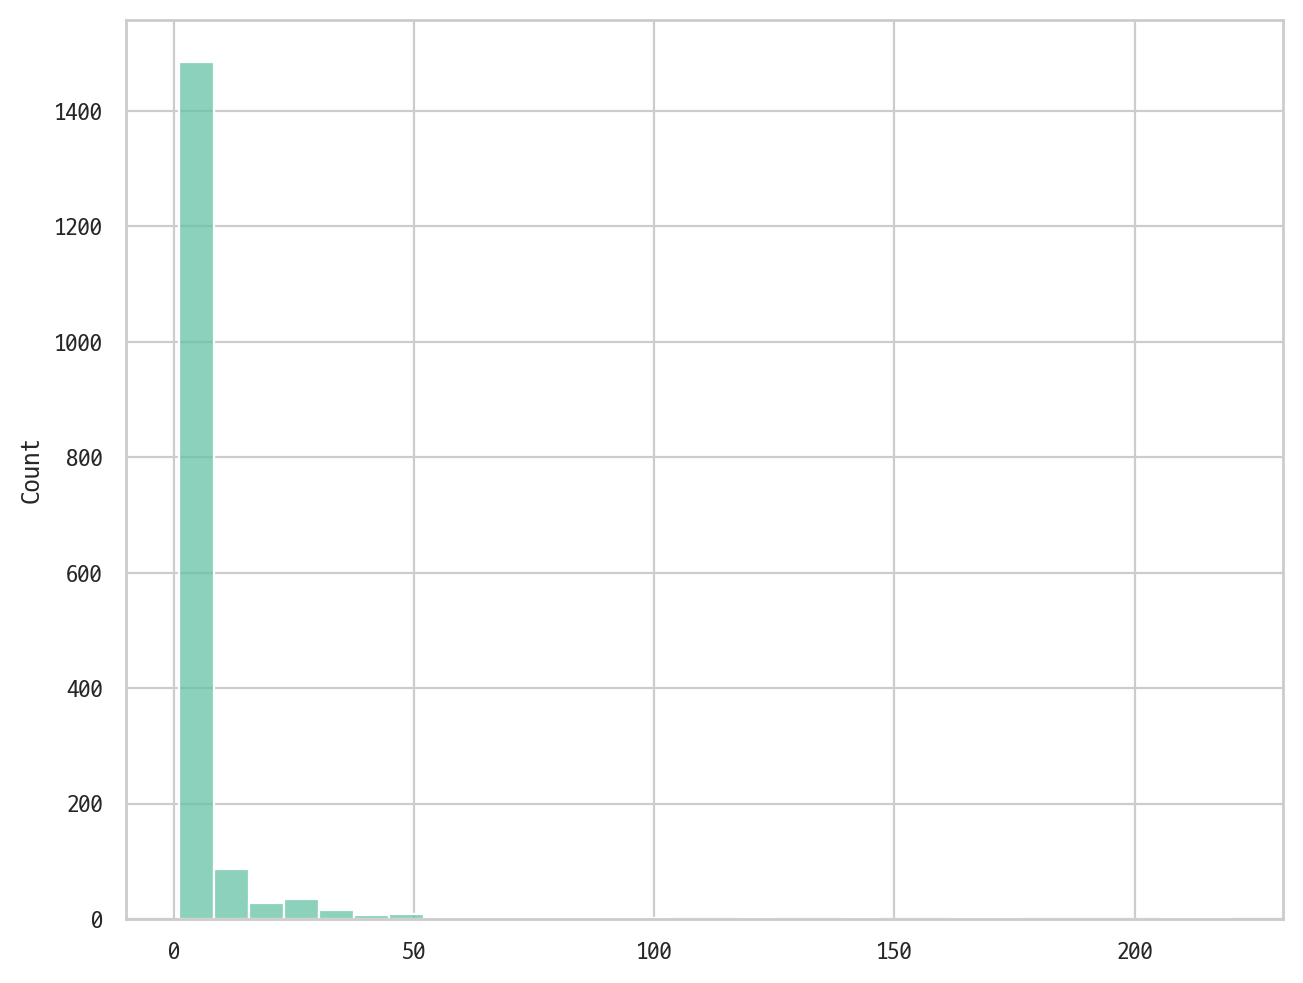

In [87]:
sns.histplot(bookinfo.Publshr.value_counts().values,bins=30);

In [88]:
stats = bookinfo.Publshr.value_counts()
cond = stats > 10
stats[cond]

Publshr
대원씨아이(만화)          220
학산문화사(만화)          216
문학동네               210
서울미디어코믹스(서울문화사)    169
민음사                167
                  ... 
보리                  11
청림Life              11
로크미디어               11
해커스금융               11
푸른역사                11
Name: count, Length: 166, dtype: int64

In [94]:
stats = bookinfo.Publshr.value_counts()
cond = stats >= 20
stats[cond]

Publshr
대원씨아이(만화)          220
학산문화사(만화)          216
문학동네               210
서울미디어코믹스(서울문화사)    169
민음사                167
                  ... 
학산문화사(라이트노벨)        22
(주)YBM(와이비엠)        21
한언출판사               21
토네이도                20
문학사상사               20
Name: count, Length: 94, dtype: int64

In [97]:
stats.iloc[0:50]

Publshr
대원씨아이(만화)            220
학산문화사(만화)            216
문학동네                 210
서울미디어코믹스(서울문화사)      169
민음사                  167
해커스어학연구소(Hackers)    146
창비                   145
길벗                   125
위즈덤하우스               122
김영사                  121
영진.com(영진닷컴)          96
문학과지성사                93
열린책들                  87
21세기북스                86
디앤씨미디어(주)(D&C미디어)     81
에스티앤북스(ST&BOOKS)      80
㈜소미미디어                73
에스티유니타스               71
해냄                    64
웅진지식하우스               62
에듀윌                   61
랜덤하우스코리아              58
알에이치코리아(RHK)          56
영상출판미디어(주)            52
넥서스                   51
두란노                   49
한길사                   47
한겨레출판                 46
서울문화사                 46
황금가지                  45
은행나무                  45
현대지능개발사               44
까치                    43
다산북스                  42
메가스터디교육(공무원)          42
비즈니스북스                39
쌤앤파커스                 39
시공사                   37
사계절                   37
와이비엠             

- 상위 50위 기준으로 ths 만들어서 선택
- 분류 별로 하는 것을 확인해보는 것도 가능할 듯
- 출판사 명에 괄호가 있는 것 때문에 같은 출판사가 다르게 등록된 것은 없는지 확인

#### 분류

In [84]:
bookinfo.Category.value_counts()

Category
소설/시/희곡      1735
만화           1033
수험서/자격증       850
인문학           676
에세이           609
경제경영          603
외국어           587
자기계발          518
사회과학          336
좋은부모          305
종교/역학         302
컴퓨터/모바일       287
청소년           253
역사            220
예술/대중문화       214
건강/취미         201
과학            187
요리/살림         181
여행             74
대학교재/전문서적      65
어린이            64
유아             21
달력/기타           4
고전              3
Name: count, dtype: int64

- token들 numbering할 때 제목, roles과 합쳐서 하면 될 듯

#### 저서 명
- \[\], \(\)로 되어있는 패턴들은 다 필터
- 수합해서 내용 확인

In [186]:
patterns=dict()
patterns['['] = r'\[+[^\[\]]+\]+'
patterns['{'] = r'\{+[^\{\}]+\}+'
patterns['('] = r'\(+[^\(\)]+\)+'

def re_iter_to_rslt(re_iter):
    return {
        m.start() : m.group()
        for m in re_iter
    }
    
def find_patterns(patterns,sentence):
    return {
        key : re_iter_to_rslt(re.finditer(pat,sentence.strip()))
        for key,pat in patterns.items()
    }

In [140]:
sent = '[신간] 최고 인기 [[안녕하세요]] 환영합니다'
temp = re.finditer(patterns['['],sent)

In [141]:
display(temp.__sizeof__())
for m in temp:
#    display(m.__dir__())
    display(m.group())
    display(m.groups())
    display(m.groupdict())
    display(m.start())
    display(m.end())
    display(m.pos)
    break

32

'[신간]'

()

{}

0

4

0

In [146]:
titles = bookinfo['BName']

In [187]:
import itertools

temp = titles.apply(lambda x : find_patterns(patterns,x))
display(temp.iloc[0])
display(list(map(len,list(temp.iloc[0].values()))))
display(sum(list(map(len,list(temp.iloc[0].values())))))

{'[': {}, '{': {}, '(': {}}

[0, 0, 0]

0

In [188]:
display(sum(map(len,temp.iloc[-1].values())))

1

In [189]:
count_all_ele = lambda x: sum(map(len,x.values()))
cond = temp.apply(count_all_ele)>0
temp[cond]

67            {'[': {}, '{': {}, '(': {15: '(교재 + 테이프)'}}
101                  {'[': {}, '{': {}, '(': {7: '(합본)'}}
162                  {'[': {}, '{': {}, '(': {5: '(양장)'}}
180            {'[': {}, '{': {}, '(': {7: '(교재 + 칠교판)'}}
193        {'[': {}, '{': {}, '(': {12: '(교재 + 테이프 3개)'}}
                              ...                        
9286                 {'[': {}, '{': {}, '(': {7: '(양장)'}}
9299    {'[': {}, '{': {}, '(': {14: '(기출지문 암기 App 이용쿠...
9303             {'[': {}, '{': {}, '(': {13: '(최신개정판)'}}
9306               {'[': {}, '{': {}, '(': {12: '(한정판)'}}
9327               {'[': {}, '{': {}, '(': {13: '(양장본)'}}
Name: BName, Length: 883, dtype: object

In [211]:
def clear_patterns(patterns:dict,sentence):
    for pat in patterns.values() :
        sentence = re.sub(pat,'',sentence).strip()
        sentence = re.sub(r'\s+',' ',sentence).strip()
    return sentence

In [212]:
sent = '[신간] 최고 인기 [[안녕하세요]] 환영합니다 [(안녕)]하세요'
temp = re.finditer(patterns['['],sent)
display(find_patterns(patterns,sent))
re.sub(patterns['['],'',sent)

{'[': {0: '[신간]', 11: '[[안녕하세요]]', 27: '[(안녕)]'}, '{': {}, '(': {28: '(안녕)'}}

' 최고 인기  환영합니다 하세요'

In [213]:
display(clear_patterns(patterns,sent))

'최고 인기 환영합니다 하세요'

In [214]:
display(titles)
display(titles.apply(lambda x : clear_patterns(patterns,x)))

0               민병철 생활영어 1
1                  행복에의 초대
2               훈련으로 되는 제자
3                   전태일 평전
4                    제자의 삶
               ...        
9323            장송의 프리렌 12
9324            약사의 혼잣말 13
9325      타몬 군 지금 어느 쪽?! 7
9326           천재 의사 시건방 1
9327    전지적 루이&후이 시점 (양장본)
Name: BName, Length: 9328, dtype: object

0             민병철 생활영어 1
1                행복에의 초대
2             훈련으로 되는 제자
3                 전태일 평전
4                  제자의 삶
              ...       
9323          장송의 프리렌 12
9324          약사의 혼잣말 13
9325    타몬 군 지금 어느 쪽?! 7
9326         천재 의사 시건방 1
9327        전지적 루이&후이 시점
Name: BName, Length: 9328, dtype: object

- 권 정보는 따로 분리 안해도 될 듯

## 정리하여 적용
- 저자명 : 1저자만 추출
    - ```extract_author1``` 사용
    - 공저자 등이 있는지에 대한 bool columns을 만듦
- 도서명 : 괄호 안의 내용 분리
    - 각 괄호 별로 들어있는 내용을 추출한 뒤 ', '.join
- 출판사 : 상위 50개를 제외하고는 기타 처리
- 대분류 : 별도의 처리 하지 않되 token 코퍼스에 추가

In [215]:
bookinfo

,Rank,Partition,BName,ItemId,ISBN13,AddCode,Author,Publshr,Pdate,RglPrice,SlsPrice,Mileage,SalesPoint,Category,Sorce
0,322.0,국내도서,민병철 생활영어 1,54947,9788975121036,13740.0,민병철 지음,민병철스피킹웍스,1979-10-01,5500,4950,270점,177.0,외국어,2001년1월3주
1,767.0,국내도서,행복에의 초대,168173,9788932852218,93230.0,IVP(한국기독학생회출판부) 편집부 엮음,IVP,1979-12-01,2800,2660,20점,1960.0,종교/역학,2005년2월1주
2,449.0,국내도서,훈련으로 되는 제자,458277,9788937501791,NaN,월터 A. 헨릭슨 지음,네비게이토,1980-12-01,4500,4050,220점,552.0,종교/역학,2005년2월1주
3,490.0,국내도서,전태일 평전,128759,9788971990650,NaN,조영래 지음,돌베개,1983-06-01,6000,6000,60점,409.0,사회과학,2001년1월3주
4,300.0,국내도서,제자의 삶,131488,9788937502590,3230.0,프랜시스 M.코스그로브 지음,네비게이토,1984-07-01,12000,12000,360점,1110.0,종교/역학,2005년2월1주
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,68.0,국내도서,장송의 프리렌 12,342597187,9791141131623,NaN,"야마다 카네히토 지음, 아베 츠카사 그림, 서현아 옮김",학산문화사(만화),2024-07-25,6000,5400,300점,10530.0,만화,2024년7월2주
9324,138.0,국내도서,약사의 혼잣말 13,342597589,9791141137175,NaN,"네코쿠라게 지음, 시노 토우코 그림, 휴우가 나츠 원작, 나나오 이츠키 구성",학산문화사(만화),2024-07-25,6000,5400,300점,5870.0,만화,2024년7월2주
9325,129.0,국내도서,타몬 군 지금 어느 쪽?! 7,342597714,9791141131678,NaN,"시와스 유키 지음, 최윤정 옮김",학산문화사(만화),2024-07-25,6000,5400,300점,6370.0,만화,2024년7월2주
9326,209.0,국내도서,천재 의사 시건방 1,342388828,9791160342147,74810,"강효미 지음, 유영근 그림",머스트비,2024-07-31,13000,11700,650점,8190.0,어린이,2024년7월2주


In [217]:
bookinfo.columns

Index(['Rank', 'Partition', 'BName', 'ItemId', 'ISBN13', 'AddCode', 'Author',
       'Publshr', 'Pdate', 'RglPrice', 'SlsPrice', 'Mileage', 'SalesPoint',
       'Category', 'Sorce'],
      dtype='object')

In [231]:
bookinfo_processed = bookinfo.copy()
cols = ['Rank','BName','ItemId','Author',
       'Publshr','Pdate','RglPrice','SlsPrice','SalesPoint',
       'Category','Sorce'] 
bookinfo_processed = bookinfo_processed[cols]

In [232]:
import itertools

titles = bookinfo['BName']
temp = titles.apply(lambda x : find_patterns(patterns,x))
temp2 = pd.DataFrame(data = [np.nan]*len(temp),index = temp.index)
for parens in patterns.keys():
    temp2[f'con_{parens}'] = temp.apply(lambda x: ', '.join(list(x[parens].values())))

paren_cols = list(map(lambda x : f'con_{x}',patterns.keys()))
bookinfo_processed['BName_sub'] = temp2[paren_cols].apply(lambda x : ', '.join(
    (filter(lambda y : y !='',x))),axis=1)
bookinfo_processed['BName'] = titles.apply(lambda x : clear_patterns(patterns,x))

bookinfo_processed

,Rank,BName,ItemId,Author,Publshr,Pdate,RglPrice,SlsPrice,SalesPoint,Category,Sorce,BName_sub
0,322.0,민병철 생활영어 1,54947,민병철 지음,민병철스피킹웍스,1979-10-01,5500,4950,177.0,외국어,2001년1월3주,
1,767.0,행복에의 초대,168173,IVP(한국기독학생회출판부) 편집부 엮음,IVP,1979-12-01,2800,2660,1960.0,종교/역학,2005년2월1주,
2,449.0,훈련으로 되는 제자,458277,월터 A. 헨릭슨 지음,네비게이토,1980-12-01,4500,4050,552.0,종교/역학,2005년2월1주,
3,490.0,전태일 평전,128759,조영래 지음,돌베개,1983-06-01,6000,6000,409.0,사회과학,2001년1월3주,
4,300.0,제자의 삶,131488,프랜시스 M.코스그로브 지음,네비게이토,1984-07-01,12000,12000,1110.0,종교/역학,2005년2월1주,
...,...,...,...,...,...,...,...,...,...,...,...,...
9323,68.0,장송의 프리렌 12,342597187,"야마다 카네히토 지음, 아베 츠카사 그림, 서현아 옮김",학산문화사(만화),2024-07-25,6000,5400,10530.0,만화,2024년7월2주,
9324,138.0,약사의 혼잣말 13,342597589,"네코쿠라게 지음, 시노 토우코 그림, 휴우가 나츠 원작, 나나오 이츠키 구성",학산문화사(만화),2024-07-25,6000,5400,5870.0,만화,2024년7월2주,
9325,129.0,타몬 군 지금 어느 쪽?! 7,342597714,"시와스 유키 지음, 최윤정 옮김",학산문화사(만화),2024-07-25,6000,5400,6370.0,만화,2024년7월2주,
9326,209.0,천재 의사 시건방 1,342388828,"강효미 지음, 유영근 그림",머스트비,2024-07-31,13000,11700,8190.0,어린이,2024년7월2주,


In [241]:
bookinfo_processed['BName_sub'].value_counts()

BName_sub
                      8445
(양장)                    50
(반양장)                   27
(무선)                    22
(스프링)                   20
                      ... 
(2014~2015년 최신개정판)       1
(2015년용)                 1
(2014년)                  1
(60만 부 기념 스페셜 에디션)       1
(2024 하편)                1
Name: count, Length: 493, dtype: int64

In [238]:
k = 50
stats = bookinfo['Publshr'].value_counts().sort_values(ascending=False)
top_k_val = stats.iloc[k]
publs_top_k = list(stats[stats >= top_k_val].index)
len(publs_top_k)
#top k 정하는 것은 완전 합본 후에 정해야 함

52

In [240]:
cond_etc = ~(bookinfo['Publshr'].isin(publs_top_k))
bookinfo_processed.loc[cond_etc,'Publshr'] =  '기타 출판사'
display(len(bookinfo_processed['Publshr'].unique()))
display(bookinfo_processed['Publshr'].value_counts())

53

Publshr
기타 출판사               5576
대원씨아이(만화)             220
학산문화사(만화)             216
문학동네                  210
서울미디어코믹스(서울문화사)       169
민음사                   167
해커스어학연구소(Hackers)     146
창비                    145
길벗                    125
위즈덤하우스                122
김영사                   121
영진.com(영진닷컴)           96
문학과지성사                 93
열린책들                   87
21세기북스                 86
디앤씨미디어(주)(D&C미디어)      81
에스티앤북스(ST&BOOKS)       80
㈜소미미디어                 73
에스티유니타스                71
해냄                     64
웅진지식하우스                62
에듀윌                    61
랜덤하우스코리아               58
알에이치코리아(RHK)           56
영상출판미디어(주)             52
넥서스                    51
두란노                    49
한길사                    47
서울문화사                  46
한겨레출판                  46
은행나무                   45
황금가지                   45
현대지능개발사                44
까치                     43
다산북스                   42
메가스터디교육(공무원)           42
비즈니스북스                 39
쌤앤파커스                  39
시공사 

In [242]:
authors = bookinfo['Author']
cond_mul = authors.str.split(',').apply(len) > 1
bookinfo_processed['Author'] = authors.apply(extract_author1)
bookinfo_processed['Author_mul'] = cond_mul

bookinfo_processed

,Rank,BName,ItemId,Author,Publshr,Pdate,RglPrice,SlsPrice,SalesPoint,Category,Sorce,BName_sub,Author_mul
0,322.0,민병철 생활영어 1,54947,민병철,기타 출판사,1979-10-01,5500,4950,177.0,외국어,2001년1월3주,,False
1,767.0,행복에의 초대,168173,IVP(한국기독학생회출판부) 편집부,기타 출판사,1979-12-01,2800,2660,1960.0,종교/역학,2005년2월1주,,False
2,449.0,훈련으로 되는 제자,458277,월터 A. 헨릭슨,기타 출판사,1980-12-01,4500,4050,552.0,종교/역학,2005년2월1주,,False
3,490.0,전태일 평전,128759,조영래,돌베개,1983-06-01,6000,6000,409.0,사회과학,2001년1월3주,,False
4,300.0,제자의 삶,131488,프랜시스 M.코스그로브,기타 출판사,1984-07-01,12000,12000,1110.0,종교/역학,2005년2월1주,,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,68.0,장송의 프리렌 12,342597187,야마다 카네히토,학산문화사(만화),2024-07-25,6000,5400,10530.0,만화,2024년7월2주,,True
9324,138.0,약사의 혼잣말 13,342597589,네코쿠라게,학산문화사(만화),2024-07-25,6000,5400,5870.0,만화,2024년7월2주,,True
9325,129.0,타몬 군 지금 어느 쪽?! 7,342597714,시와스 유키,학산문화사(만화),2024-07-25,6000,5400,6370.0,만화,2024년7월2주,,True
9326,209.0,천재 의사 시건방 1,342388828,강효미,기타 출판사,2024-07-31,13000,11700,8190.0,어린이,2024년7월2주,,True


In [245]:
new_cols = cols.copy()
new_cols.insert(4,'Author_mul')
new_cols.insert(2,'BName_sub')
display(new_cols)
bookinfo_processed = bookinfo_processed[new_cols]
display(bookinfo_processed)

['Rank',
 'BName',
 'BName_sub',
 'ItemId',
 'Author',
 'Author_mul',
 'Publshr',
 'Pdate',
 'RglPrice',
 'SlsPrice',
 'SalesPoint',
 'Category',
 'Sorce']

,Rank,BName,BName_sub,ItemId,Author,Author_mul,Publshr,Pdate,RglPrice,SlsPrice,SalesPoint,Category,Sorce
0,322.0,민병철 생활영어 1,,54947,민병철,False,기타 출판사,1979-10-01,5500,4950,177.0,외국어,2001년1월3주
1,767.0,행복에의 초대,,168173,IVP(한국기독학생회출판부) 편집부,False,기타 출판사,1979-12-01,2800,2660,1960.0,종교/역학,2005년2월1주
2,449.0,훈련으로 되는 제자,,458277,월터 A. 헨릭슨,False,기타 출판사,1980-12-01,4500,4050,552.0,종교/역학,2005년2월1주
3,490.0,전태일 평전,,128759,조영래,False,돌베개,1983-06-01,6000,6000,409.0,사회과학,2001년1월3주
4,300.0,제자의 삶,,131488,프랜시스 M.코스그로브,False,기타 출판사,1984-07-01,12000,12000,1110.0,종교/역학,2005년2월1주
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,68.0,장송의 프리렌 12,,342597187,야마다 카네히토,True,학산문화사(만화),2024-07-25,6000,5400,10530.0,만화,2024년7월2주
9324,138.0,약사의 혼잣말 13,,342597589,네코쿠라게,True,학산문화사(만화),2024-07-25,6000,5400,5870.0,만화,2024년7월2주
9325,129.0,타몬 군 지금 어느 쪽?! 7,,342597714,시와스 유키,True,학산문화사(만화),2024-07-25,6000,5400,6370.0,만화,2024년7월2주
9326,209.0,천재 의사 시건방 1,,342388828,강효미,True,기타 출판사,2024-07-31,13000,11700,8190.0,어린이,2024년7월2주


In [247]:
file_name = 'bookinfo_ver0.csv'
save_path = os.path.join(PRJCT_PATH,'processed',file_name)
bookinfo_processed.to_csv(save_path,index=False)